In [1]:
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from skimage.transform import resize
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint





In [2]:
dirname = os.path.join(os.getcwd(), '/home/ruben/Escritorio/imagenes_Clasi_ Manual')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            height,width=64, 80
            image_resized = cv2.resize(image, ( width,height))
            images.append(image_resized)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /home/ruben/Escritorio/imagenes_Clasi_ Manual/
/home/ruben/Escritorio/imagenes_Clasi_ Manual/recto rapido 1
/home/ruben/Escritorio/imagenes_Clasi_ Manual/derecha 932
/home/ruben/Escritorio/imagenes_Clasi_ Manual/izquierda 409
/home/ruben/Escritorio/imagenes_Clasi_ Manual/recto lento 612
Directorios leidos: 4
Imagenes en cada directorio [933, 409, 612, 607]
suma Total de imagenes en subdirs: 2561


In [3]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

mov=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    mov.append(name[len(name)-1])
    indice=indice+1

Y = np.array(labels)
X = np.array(images, dtype=np.uint8) 

classes = np.unique(Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)


Cantidad etiquetas creadas:  2561
0 recto rapido
1 derecha
2 izquierda
3 recto lento
Total number of outputs :  4
Output classes :  [0 1 2 3]


In [4]:
#para aumentar e igualar imagenes en los giros
images_aug,labels_aug=[],[]
for image_aux,label_aux in zip(X,Y):
    images_aug.append(image_aux)
    labels_aug.append(label_aux)
    images_aug.append(cv2.flip(image_aux,1))
    if label_aux==1:
        labels_aug.append(2)
    elif label_aux==2:
        labels_aug.append(1)
    else:
        labels_aug.append(label_aux)
a = np.array(images_aug, dtype=np.uint8)
b = np.array(labels_aug) 
print(a.shape)
print(b.shape)
X=a
Y=b




(5122, 64, 80, 3)
(5122,)


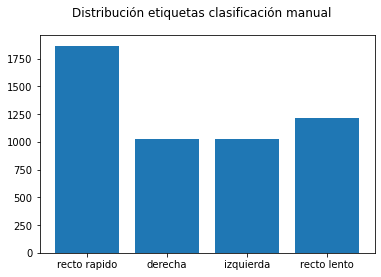

In [5]:
count=[0,0,0,0]
move=["",2,3,4]
for m in zip(Y):
    if(m)==(0,):
        count[0]=1+count[0]
    if(m)==(1,):
        count[1]=1+count[1]
    if(m)==(2,):
        count[2]=1+count[2]
    if(m)==(3,):
        count[3]=1+count[3]
plt.subplot()
plt.bar( mov,count)
plt.suptitle('Distribución etiquetas clasificación manual')
plt.show()

In [6]:
train_X,test_X,train_Y,test_Y = train_test_split(X,Y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Training data shape :  (4097, 64, 80, 3) (4097,)
Testing data shape :  (1025, 64, 80, 3) (1025,)
(3277, 64, 80, 3) (820, 64, 80, 3) (3277, 4) (820, 4)


In [7]:
INIT_LR = 1e-3
epochs = 15
batch_size = 64

move_model = Sequential()

move_model.add(Conv2D(32, kernel_size=(3,3),activation='linear',padding='same',input_shape=(height,width,3)))
move_model.add(LeakyReLU(alpha=0.1))

move_model.add(MaxPooling2D((2,2),padding='same'))
move_model.add(Dropout(0.5))

move_model.add(Flatten())
move_model.add(Dense(50, activation='linear'))
move_model.add(LeakyReLU(alpha=0.1))
move_model.add(Dropout(0.5)) 
move_model.add(Dense(nClasses, activation='softmax'))

move_model.summary()

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                             monitor='val_accuracy',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

move_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 80, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 80, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 40, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 40, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                2048050   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0

In [8]:
print(train_X.shape)


(3277, 64, 80, 3)


In [9]:
move_train = move_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label),callbacks=[checkpoint])
test_eval = move_model.evaluate(test_X, test_Y_one_hot, verbose=1)
print(train_X.shape)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Epoch 1/15
52/52 [==============================] - 10s 190ms/step - loss: 1.7199 - accuracy: 0.4895 - val_loss: 0.7144 - val_accuracy: 0.7073
Epoch 2/15
52/52 [==============================] - 11s 214ms/step - loss: 0.6004 - accuracy: 0.7833 - val_loss: 0.4592 - val_accuracy: 0.8427
Epoch 3/15
52/52 [==============================] - 11s 220ms/step - loss: 0.4239 - accuracy: 0.8557 - val_loss: 0.4692 - val_accuracy: 0.8427
Epoch 4/15
52/52 [==============================] - 11s 214ms/step - loss: 0.3734 - accuracy: 0.8813 - val_loss: 0.3217 - val_accuracy: 0.9061
Epoch 5/15
52/52 [==============================] - 11s 215ms/step - loss: 0.3081 - accuracy: 0.9014 - val_loss: 0.4040 - val_accuracy: 0.8573
Epoch 6/15
52/52 [==============================] - 14s 280ms/step - loss: 0.2759 - accuracy: 0.9078 - val_loss: 0.3331 - val_accuracy: 0.8854
Epoch 7/15
52/52 [==============================] - 14s 273ms/step - loss: 0.2505 - accuracy: 0.9204 - val_loss: 0.2943 - val_accuracy: 0.8890

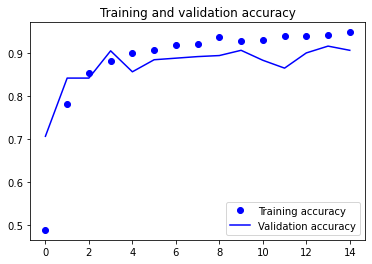

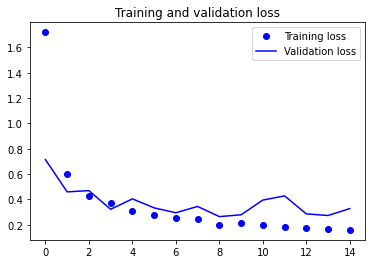

In [10]:
accuracy = move_train.history['accuracy']
val_accuracy = move_train.history['val_accuracy']
loss = move_train.history['loss']
val_loss = move_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
predicted_classes2 = move_model.predict(test_X)

In [12]:
predicted_classes=[]
for predicted_move in predicted_classes2:
    predicted_classes.append(predicted_move.tolist().index(max(predicted_move)))
predicted_classes=np.array(predicted_classes)

In [13]:
predicted_classes.shape, test_Y.shape


((1025,), (1025,))

Found 959 correct labels


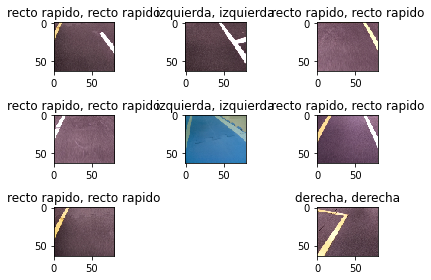

In [14]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(height, width,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(mov[predicted_classes[correct]],
                                                    mov[test_Y[correct]]))

    plt.tight_layout()

Found 66 incorrect labels


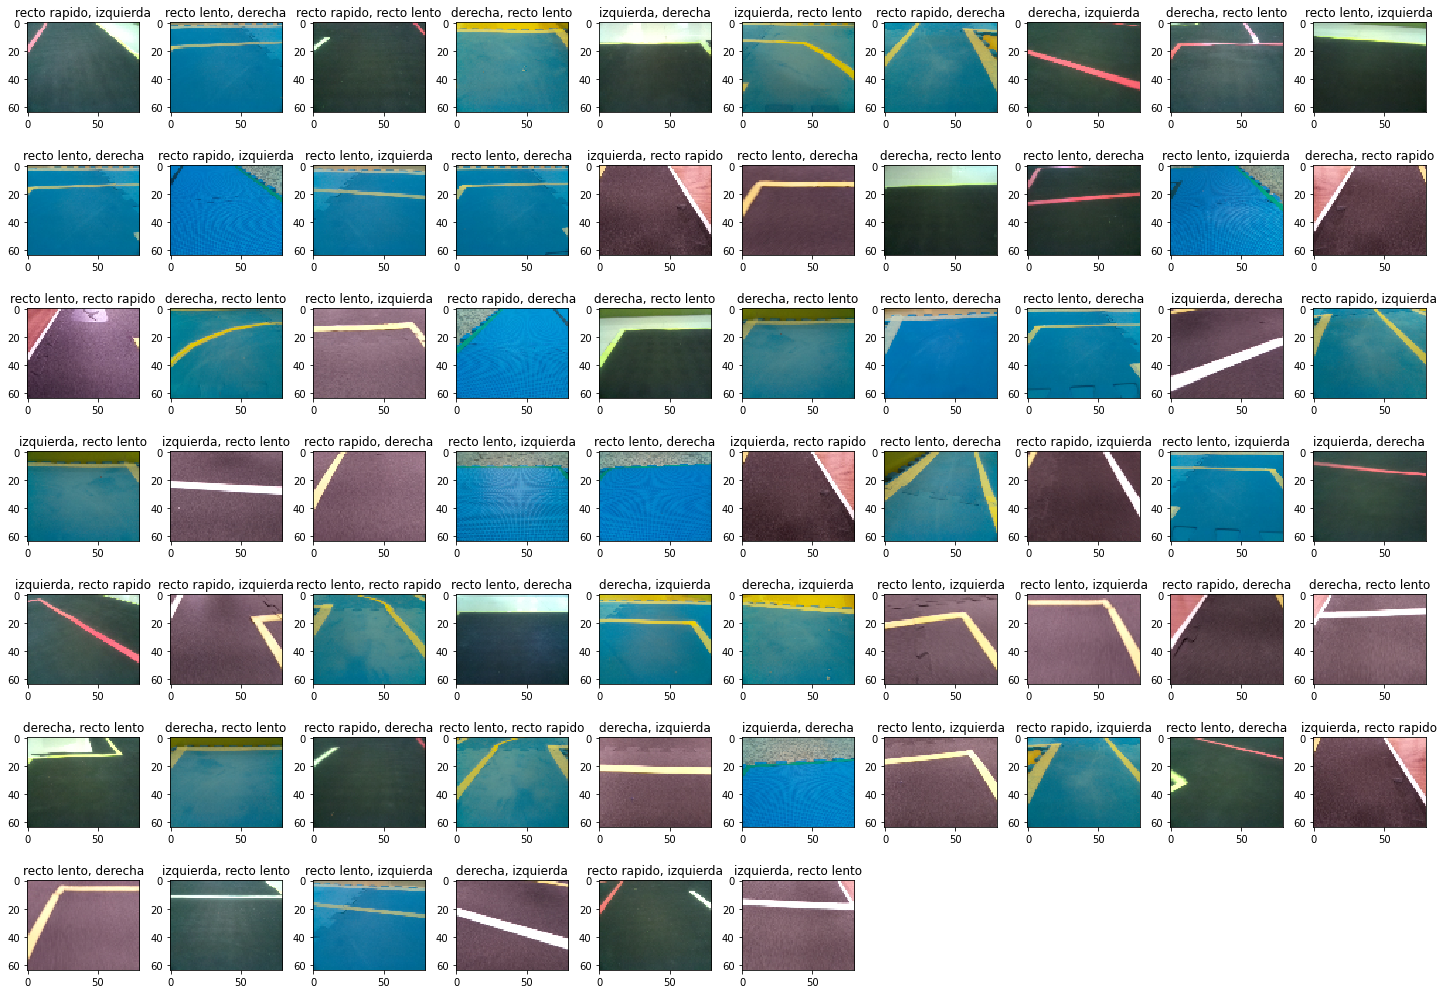

In [15]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
plt.figure(figsize=(20,20))
for i, incorrect in enumerate(incorrect):
    plt.subplot(10,10,i+1)
    plt.imshow(test_X[incorrect].reshape(height, width,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(mov[predicted_classes[incorrect]],
                                                    mov[test_Y[incorrect]]))
    plt.tight_layout()


In [16]:
move_model.save("prueba.h5")

In [17]:
new_model = keras.models.load_model('move4.h5')



OSError: SavedModel file does not exist at: move4.h5/{saved_model.pbtxt|saved_model.pb}

In [ ]:

from skimage.transform import resize 
 

images=[]
filenames = ['test/test1.jpg']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (height, width),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) 
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = new_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], mov[img_tagged.tolist().index(max(img_tagged))])

In [ ]:
dirname = os.path.join(os.getcwd(), '/home/ruben/Escritorio/derecha')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            height,width=60, 80
            image_resized = resize(image, (height, width),anti_aliasing=True,clip=False,preserve_range=True)
            images.append(image_resized)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))